In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import re
from wordcloud import WordCloud


In [6]:
# torch imports

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer

In [7]:
# NLTK specific imports and downloads

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
df = pd.read_csv('/content/Youtube-Spam-Dataset.csv')

In [9]:
df.columns = [col.lower() for col in df.columns]
print(df.columns)

Index(['comment_id', 'author', 'date', 'content', 'video_name', 'class'], dtype='object')


In [10]:
df.describe()

,class
count,1956.000000
mean,0.513804
std,0.499937
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [11]:
# Drop irrelevant columns
df.drop(['comment_id', 'author'], axis=1, inplace=True)

In [12]:
# Clean the content column
df["content"] = df["content"].str.replace(r"http\S+", "")  # Remove URLs
df["content"] = df["content"].str.replace(r"http", "")  # Remove "http"
df["content"] = df["content"].str.replace(r"@\S+", "")  # Remove mentions (@username)
df["content"] = df["content"].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")  # Remove special characters
df["content"] = df["content"].str.replace(r"@", "at")  # Replace "@" with "at"
df["content"] = df["content"].str.lower()  # Convert text to lowercase

In [13]:
print(df['content'].head())

0    huh, anyway check out this you[tube] channel: ...
1    hey guys check out my new channel and our firs...
2               just for test i have to say murdev.com
3     me shaking my sexy ass on my channel enjoy ^_^ ﻿
4              watch?v=vtarggvgtwq   check this out .﻿
Name: content, dtype: object


In [14]:
X = df['content']
y = df['class']

In [15]:
# Split data into training and testing sets (80% train, 20% test)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 1564
Test set size: 392


In [16]:
# TF-IDF Vectorization (transform the text into numerical features)

vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Output the shape of the TF-IDF transformed data
print("Training Data Shape (TF-IDF):", X_train_tfidf.shape)
print("Testing Data Shape (TF-IDF):", X_test_tfidf.shape)

# Example of transformed feature vectors
print("Example of TF-IDF vectorized text:")
print(X_train_tfidf[0].toarray())

Training Data Shape (TF-IDF): (1564, 3592)
Testing Data Shape (TF-IDF): (392, 3592)
Example of TF-IDF vectorized text:
[[0. 0. 0. ... 0. 0. 0.]]


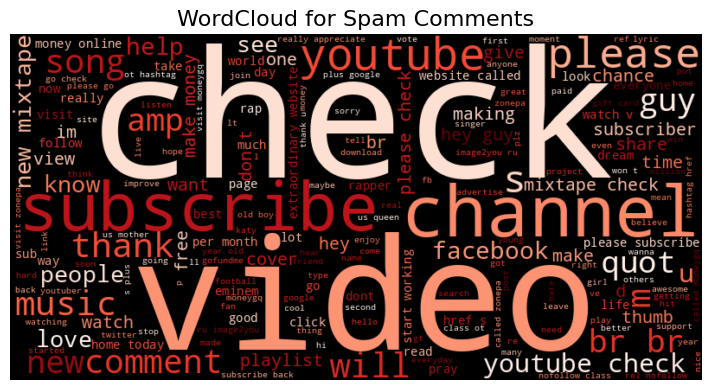

In [17]:
from wordcloud import WordCloud

spam_comments = ' '.join(df[df['class'] == 1]['content'])
spam_wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(spam_comments)

plt.figure(figsize=(8, 4))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Spam Comments', fontsize=16)
plt.tight_layout()
plt.show()

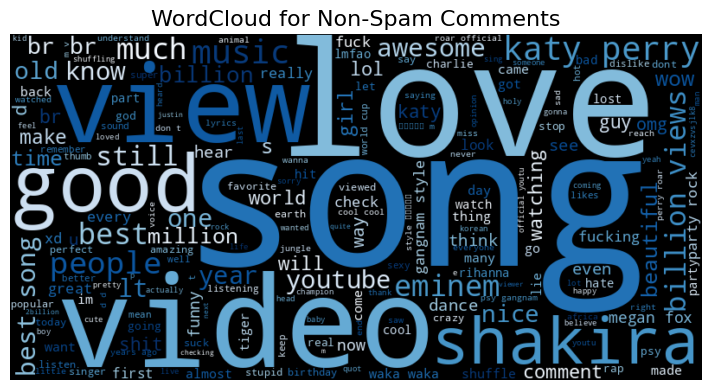

In [18]:
spam_comments = ' '.join(df[df['class'] == 0]['content'])
spam_wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Blues').generate(spam_comments)

plt.figure(figsize=(8, 4))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Non-Spam Comments', fontsize=16)
plt.tight_layout()
plt.show()

<ipython-input-19-c8b04d124461>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_data,palette='pastel')


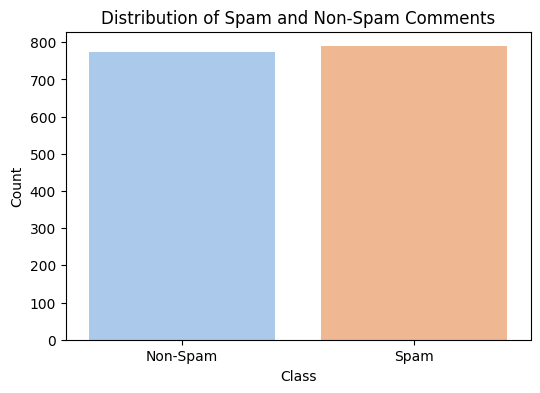

In [19]:
# Plot distribution of target classes (Spam vs Non-Spam)

def plot_target_distribution(y_data):
    plt.figure(figsize=(6, 4))
    sns.countplot(x=y_data,palette='pastel')
    plt.title('Distribution of Spam and Non-Spam Comments')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks([0, 1], ['Non-Spam', 'Spam'])
    plt.show()

plot_target_distribution(y_train)

<ipython-input-20-16c2731b41c5>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=word_freq.index, y=word_freq.values, palette='viridis')


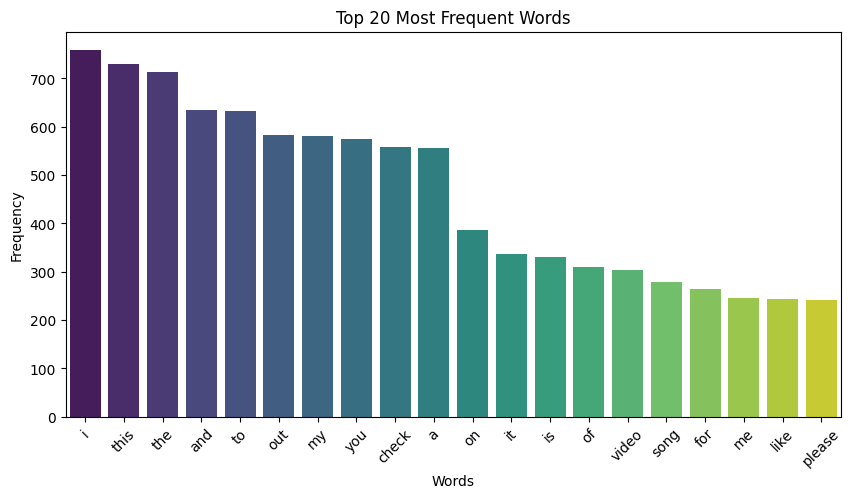

In [20]:
# Plot top N most frequent words in the dataset

def plot_word_frequency(text_data, top_n=20):
    all_words = ' '.join(text_data)
    all_words = re.sub(r'[^a-zA-Z\s]', '', all_words)  # Clean the text
    word_freq = pd.Series(all_words.split()).value_counts().head(top_n)

    plt.figure(figsize=(10, 5))
    sns.barplot(x=word_freq.index, y=word_freq.values, palette='viridis')
    plt.title(f'Top {top_n} Most Frequent Words')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

plot_word_frequency(df['content'], top_n=20)

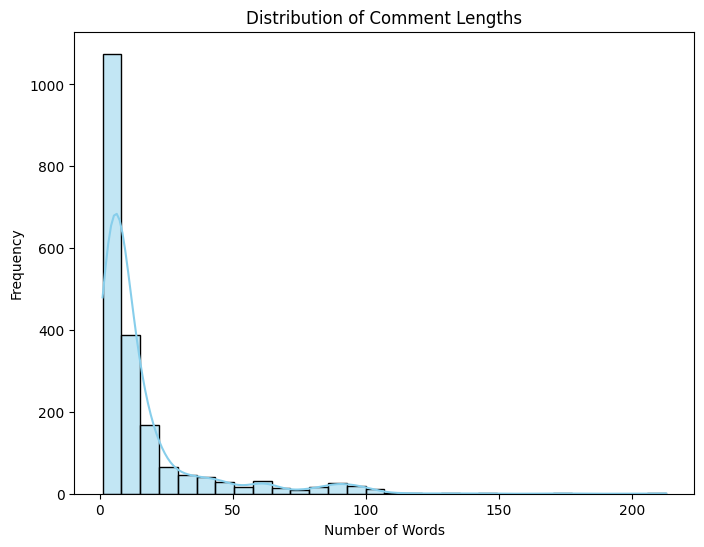

In [21]:
# Plot the distribution of comment lengths

def plot_comment_length_distribution(text_data):
    comment_lengths = text_data.apply(lambda x: len(x.split()))

    plt.figure(figsize=(8, 6))
    sns.histplot(comment_lengths, kde=True, bins=30, color='skyblue')
    plt.title('Distribution of Comment Lengths')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.show()

plot_comment_length_distribution(df['content'])

Traditional ML Models

In [22]:
#Baseline model - Logistic regression

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000, random_state=42)

model.fit(X_train_tfidf, y_train)

lr_pred = model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, lr_pred)

print("Accuracy:", accuracy)

Accuracy: 0.9413265306122449


In [23]:
print(classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       176
           1       0.97      0.92      0.95       216

    accuracy                           0.94       392
   macro avg       0.94      0.94      0.94       392
weighted avg       0.94      0.94      0.94       392



In [24]:
#SVM

from sklearn.svm import SVC

kernels = ['linear', 'poly', 'rbf']
svm_accuracy = {}

for k in kernels:
    svm = SVC(kernel=k, random_state=42)
    svm.fit(X_train_tfidf, y_train)
    svm_pred = svm.predict(X_test_tfidf)

    svm_accuracy[k] = accuracy_score(y_test, svm_pred)

    print(f"SVM Kernel Function: {k}")
    print("Accuracy:", svm_accuracy[k])
    print(classification_report(y_test, svm_pred))

svm_accuracy['SVM (Linear)'] = svm_accuracy['linear']
svm_accuracy['SVM (Poly)'] = svm_accuracy['poly']
svm_accuracy['SVM (RBF)'] = svm_accuracy['rbf']

SVM Kernel Function: linear
Accuracy: 0.9489795918367347
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       176
           1       0.97      0.94      0.95       216

    accuracy                           0.95       392
   macro avg       0.95      0.95      0.95       392
weighted avg       0.95      0.95      0.95       392

SVM Kernel Function: poly
Accuracy: 0.9030612244897959
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       176
           1       0.92      0.90      0.91       216

    accuracy                           0.90       392
   macro avg       0.90      0.90      0.90       392
weighted avg       0.90      0.90      0.90       392

SVM Kernel Function: rbf
Accuracy: 0.9387755102040817
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       176
           1       0.97      0.92      0.94       216

    accuracy    

In [25]:
# Decision Tree

from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(criterion='entropy', max_depth=15, random_state=42)

dt_model.fit(X_train_tfidf, y_train)

dt_pred = dt_model.predict(X_test_tfidf)

accuracy_dt = accuracy_score(y_test, dt_pred)

print(f"Decision Tree Accuracy: {accuracy_dt * 100:.2f}%")

print("Decision Tree Classification Report:")
print(classification_report(y_test, dt_pred))


Decision Tree Accuracy: 93.62%
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       176
           1       0.98      0.90      0.94       216

    accuracy                           0.94       392
   macro avg       0.94      0.94      0.94       392
weighted avg       0.94      0.94      0.94       392



In [26]:
# Naive Bayes

from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB(alpha=0.5)

nb_model.fit(X_train_tfidf, y_train)

nb_pred = nb_model.predict(X_test_tfidf)

accuracy_nb = accuracy_score(y_test, nb_pred)

print(f"Naive Bayes Accuracy: {accuracy_nb * 100:.2f}%")

print("Naive Bayes Classification Report:")
print(classification_report(y_test, nb_pred))


Naive Bayes Accuracy: 91.33%
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       176
           1       0.91      0.94      0.92       216

    accuracy                           0.91       392
   macro avg       0.91      0.91      0.91       392
weighted avg       0.91      0.91      0.91       392



In [27]:
# XGBoost

import xgboost as xgb
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, random_state=42)

xgb_model.fit(X_train_tfidf, y_train)

xgb_pred = xgb_model.predict(X_test_tfidf)

accuracy_xgb = accuracy_score(y_test, xgb_pred)

print(f"XGBoost Accuracy: {accuracy_xgb * 100:.2f}%")

print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_pred))


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:23:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 94.13%
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       176
           1       0.97      0.92      0.95       216

    accuracy                           0.94       392
   macro avg       0.94      0.94      0.94       392
weighted avg       0.94      0.94      0.94       392



In [28]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)

rf_model.fit(X_train_tfidf, y_train)

rf_pred = rf_model.predict(X_test_tfidf)

accuracy_rf = accuracy_score(y_test, rf_pred)

print(f"Random Forest Accuracy: {accuracy_rf * 100:.2f}%")

print("Random Forest Classification Report:")
print(classification_report(y_test, rf_pred))


Random Forest Accuracy: 92.35%
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       176
           1       0.99      0.87      0.93       216

    accuracy                           0.92       392
   macro avg       0.93      0.93      0.92       392
weighted avg       0.93      0.92      0.92       392



**Using** BERT Tokenizer - CNN

In [29]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

In [30]:

def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies, epochs, model_name):

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_losses, label="Train Loss", color='blue')
    plt.plot(range(epochs), val_losses, label="Validation Loss", color='orange')
    plt.title(f'{model_name} - Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), train_accuracies, label="Train Accuracy", color='green')
    plt.plot(range(epochs), val_accuracies, label="Validation Accuracy", color='red')
    plt.title(f'{model_name} - Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [31]:
# Dataset for BERT
class BertTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].squeeze(0)  # Remove the batch dimension
        attention_mask = encoding['attention_mask'].squeeze(0)  # Remove the batch dimension

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [32]:
# Dataset for CNN
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoded = self.tokenizer(text, padding='max_length', truncation=True, max_length=self.max_len, return_tensors='pt')
        return {
            'input_ids': encoded['input_ids'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }


In [33]:
# CNN Model
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, kernel_sizes, num_filters):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (k, embed_dim)) for k in kernel_sizes
        ])
        self.fc = nn.Linear(num_filters * len(kernel_sizes), num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)
        x = [torch.relu(conv(x)).squeeze(3) for conv in self.convs]
        x = [torch.max(pool, dim=2)[0] for pool in x]
        x = torch.cat(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


In [34]:
# Training Function for BERT
def train_bert_model(train_loader, model, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()

    return total_loss / len(train_loader), correct / len(train_loader.dataset)


# Evaluation Function for BERT
def evaluate_bert_model(eval_loader, model, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for batch in eval_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()

    return total_loss / len(eval_loader), correct / len(eval_loader.dataset)


In [35]:
# Training Function for CNN
def train_cnn(model, data_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()

    return total_loss / len(data_loader), correct / len(data_loader.dataset)


# Evaluation Function for CNN
def evaluate_cnn(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()

    return total_loss / len(data_loader), correct / len(data_loader.dataset)


In [36]:
# Tokenizer Initialization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 128  # Sequence length for both models

# Prepare datasets for BERT and CNN
train_dataset_bert = BertTextDataset(X_train.tolist(), y_train.tolist(), tokenizer, max_len)
val_dataset_bert = BertTextDataset(X_test.tolist(), y_test.tolist(), tokenizer, max_len)

train_dataset_cnn = TextDataset(X_train.tolist(), y_train.tolist(), tokenizer, max_len)
val_dataset_cnn = TextDataset(X_test.tolist(), y_test.tolist(), tokenizer, max_len)

# DataLoader for BERT and CNN
train_loader_bert = DataLoader(train_dataset_bert, batch_size=16, shuffle=True)
val_loader_bert = DataLoader(val_dataset_bert, batch_size=16)

train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=16, shuffle=True)
val_loader_cnn = DataLoader(val_dataset_cnn, batch_size=16)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [37]:
# Device Setup (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [38]:
# BERT Model Initialization
model_bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)

# CNN Model Initialization
vocab_size = len(tokenizer.vocab)
embed_dim = 128
num_classes = 2
kernel_sizes = [3, 4, 5]
num_filters = 100
model_cnn = TextCNN(vocab_size, embed_dim, num_classes, kernel_sizes, num_filters).to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
# Optimizer and Loss Function
optimizer_bert = AdamW(model_bert.parameters(), lr=2e-5)
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=1e-3)

criterion = nn.CrossEntropyLoss()  # Common loss function for both models


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Epoch 1/10 - CNN Training
CNN Train Loss: 0.3543, Train Accuracy: 0.8408
CNN Validation Loss: 0.1369, Validation Accuracy: 0.9719

Epoch 2/10 - CNN Training
CNN Train Loss: 0.1239, Train Accuracy: 0.9533
CNN Validation Loss: 0.1025, Validation Accuracy: 0.9745

Epoch 3/10 - CNN Training
CNN Train Loss: 0.0757, Train Accuracy: 0.9738
CNN Validation Loss: 0.1190, Validation Accuracy: 0.9515

Epoch 4/10 - CNN Training
CNN Train Loss: 0.0422, Train Accuracy: 0.9834
CNN Validation Loss: 0.0832, Validation Accuracy: 0.9745

Epoch 5/10 - CNN Training
CNN Train Loss: 0.0239, Train Accuracy: 0.9936
CNN Validation Loss: 0.0950, Validation Accuracy: 0.9719

Epoch 6/10 - CNN Training
CNN Train Loss: 0.0198, Train Accuracy: 0.9942
CNN Validation Loss: 0.0800, Validation Accuracy: 0.9745

Epoch 7/10 - CNN Training
CNN Train Loss: 0.0175, Train Accuracy: 0.9962
CNN Validation Loss: 0.0824, Validation Accuracy: 0.9770

Epoch 8/10 - CNN Training
CNN Train Loss: 0.0177, Train Accuracy: 0.9949
CNN Valid

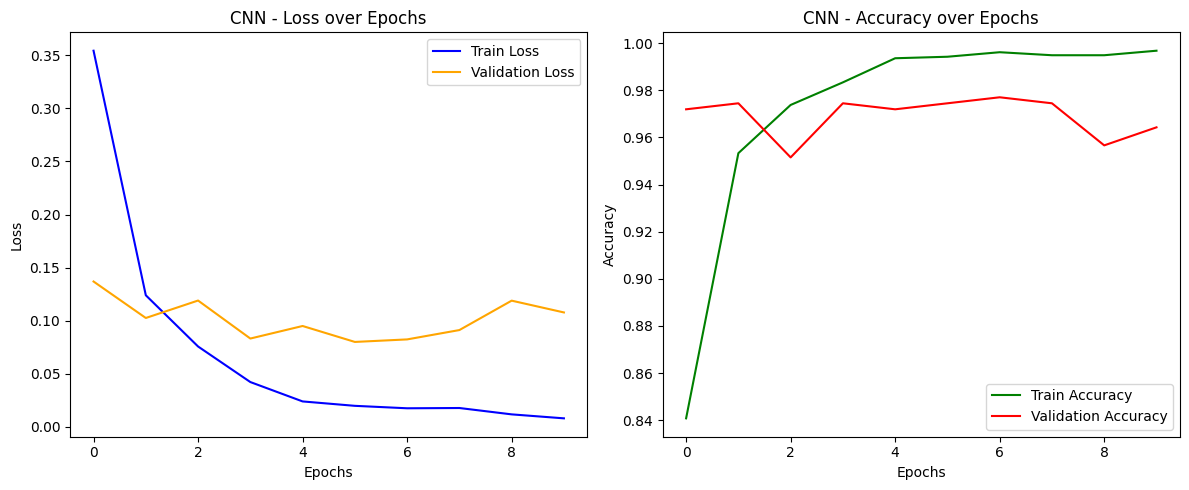

In [40]:
# For CNN
cnn_train_losses, cnn_val_losses = [], []
cnn_train_accuracies, cnn_val_accuracies = [], []

epochs = 10
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs} - CNN Training")
    train_loss_cnn, train_acc_cnn = train_cnn(model_cnn, train_loader_cnn, criterion, optimizer_cnn, device)
    val_loss_cnn, val_acc_cnn = evaluate_cnn(model_cnn, val_loader_cnn, criterion, device)

    # Store metrics
    cnn_train_losses.append(train_loss_cnn)
    cnn_val_losses.append(val_loss_cnn)
    cnn_train_accuracies.append(train_acc_cnn)
    cnn_val_accuracies.append(val_acc_cnn)

    print(f"CNN Train Loss: {train_loss_cnn:.4f}, Train Accuracy: {train_acc_cnn:.4f}")
    print(f"CNN Validation Loss: {val_loss_cnn:.4f}, Validation Accuracy: {val_acc_cnn:.4f}")

plot_training_curves(cnn_train_losses, cnn_val_losses, cnn_train_accuracies, cnn_val_accuracies, epochs=10, model_name="CNN")


Epoch 1/5 - BERT Training
BERT Train Loss: 0.2872, Train Accuracy: 0.8817
BERT Validation Loss: 0.1175, Validation Accuracy: 0.9617

Epoch 2/5 - BERT Training
BERT Train Loss: 0.0633, Train Accuracy: 0.9776
BERT Validation Loss: 0.1205, Validation Accuracy: 0.9719

Epoch 3/5 - BERT Training
BERT Train Loss: 0.0199, Train Accuracy: 0.9942
BERT Validation Loss: 0.1335, Validation Accuracy: 0.9694

Epoch 4/5 - BERT Training
BERT Train Loss: 0.0545, Train Accuracy: 0.9840
BERT Validation Loss: 0.1172, Validation Accuracy: 0.9745

Epoch 5/5 - BERT Training
BERT Train Loss: 0.0066, Train Accuracy: 0.9981
BERT Validation Loss: 0.1358, Validation Accuracy: 0.9694


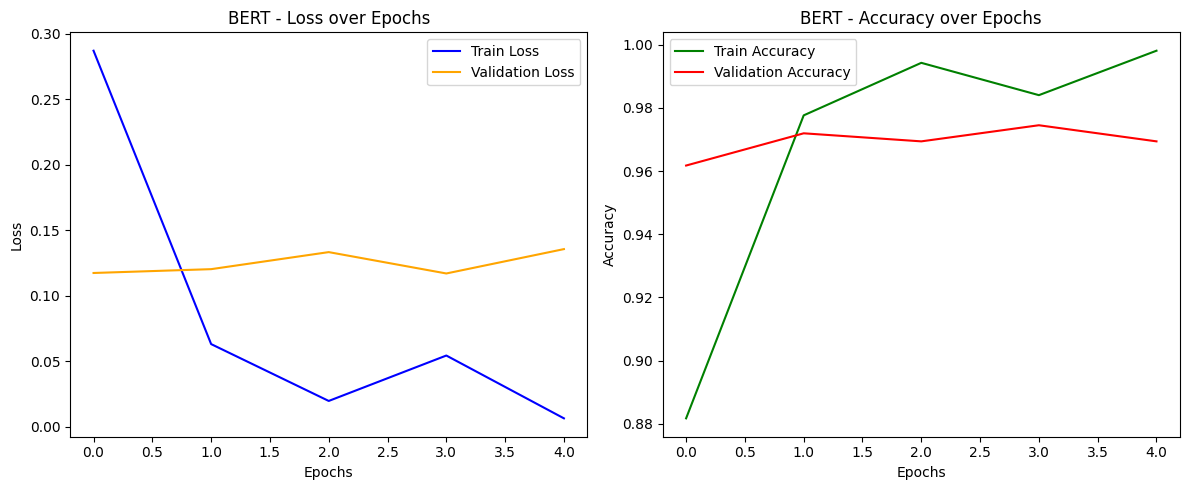

In [41]:

# For BERT
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

epochs = 5
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs} - BERT Training")
    train_loss_bert, train_acc_bert = train_bert_model(train_loader_bert, model_bert, optimizer_bert, device)
    val_loss_bert, val_acc_bert = evaluate_bert_model(val_loader_bert, model_bert, device)

    # Store metrics
    train_losses.append(train_loss_bert)
    val_losses.append(val_loss_bert)
    train_accuracies.append(train_acc_bert)
    val_accuracies.append(val_acc_bert)

    print(f"BERT Train Loss: {train_loss_bert:.4f}, Train Accuracy: {train_acc_bert:.4f}")
    print(f"BERT Validation Loss: {val_loss_bert:.4f}, Validation Accuracy: {val_acc_bert:.4f}")

plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies, epochs=5, model_name="BERT")


In [42]:
# Predict using CNN
model_cnn.eval()
cnn_pred = []
with torch.no_grad():
    for batch in val_loader_cnn:
        input_ids = batch['input_ids'].to(device)
        outputs = model_cnn(input_ids)
        preds = torch.argmax(outputs, dim=1)
        cnn_pred.extend(preds.cpu().numpy())

# Predict using BERT
model_bert.eval()
bert_pred = []
with torch.no_grad():
    for batch in val_loader_bert:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model_bert(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        bert_pred.extend(preds.cpu().numpy())

<ipython-input-43-b347e569e455>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(sorted_accuracies.keys()), y=list(sorted_accuracies.values()), palette = colors)
<ipython-input-43-b347e569e455>:16: UserWarning: 
The palette list has fewer values (8) than needed (13) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(x=list(sorted_accuracies.keys()), y=list(sorted_accuracies.values()), palette = colors)


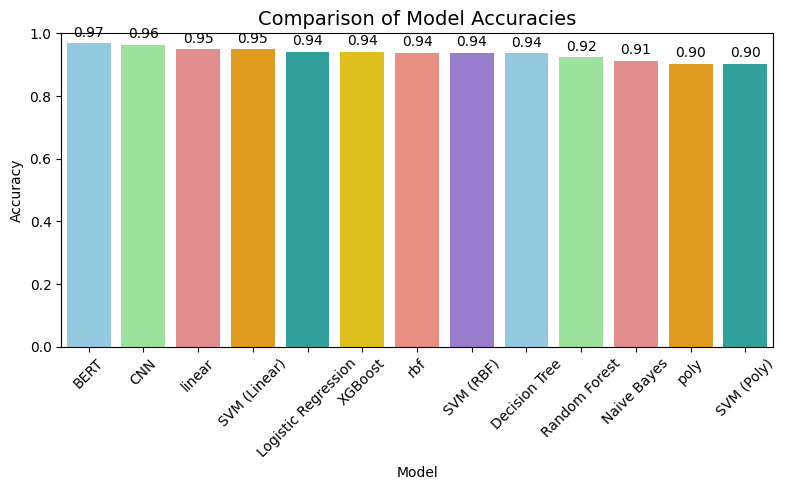

In [43]:
accuracies = {
    'Logistic Regression': accuracy_score(y_test, lr_pred),
    'Random Forest': accuracy_score(y_test, rf_pred),
    'Naive Bayes': accuracy_score(y_test, nb_pred),
    'Decision Tree': accuracy_score(y_test, dt_pred),
    'XGBoost': accuracy_score(y_test, xgb_pred),
    'CNN': accuracy_score(y_test, cnn_pred),
    'BERT': accuracy_score(y_test, bert_pred)
}

accuracies.update(svm_accuracy)
sorted_accuracies = dict(sorted(accuracies.items(), key=lambda item: item[1], reverse=True))
colors = ['skyblue', 'lightgreen', 'lightcoral', 'orange', 'lightseagreen', 'gold', 'salmon', 'mediumpurple']

plt.figure(figsize=(8, 5))
ax = sns.barplot(x=list(sorted_accuracies.keys()), y=list(sorted_accuracies.values()), palette = colors)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 0.02, f'{height:.2f}', ha='center', fontsize=10)

plt.title('Comparison of Model Accuracies', fontsize=14)
plt.xlabel('Model', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()

plt.show()